![header1](../figures/dc_2024_4dmedsea_banner.jpg) 

# Benchmark exp_20162017 4DVarNet V2 geostrophic currents maps
 

***
**Authors:**  CLS & Datlas <br>
**Copyright:** 2023 CLS & Datlas <br>
**License:** MIT

<div class="alert alert-block alert-success">
<h1><center>Benchmark exp_20162017 of 4DVarNet V2 geostrophic currents maps</center></h1> 
</div>

In [5]:
from glob import glob
import numpy as np
import os
import sys
import warnings
warnings.filterwarnings("ignore")

In [6]:
sys.path.append('..')
from src.mod_plot import *
from src.mod_stat import *
from src.mod_spectral import *
from src.mod_interp import *

In [7]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

<div class="alert alert-info" role="alert">

<h2>0. Parameters</h2>

</div>

In [8]:
time_min = '2016-01-08'                                        # time min for analysis
time_max = '2017-06-23'                                        # time max for analysis
output_dir = '../results'                                      # output directory path
os.system(f'mkdir -p {output_dir}')

box_lonlat = {'lon_min':-6,
              'lon_max':36,
              'lat_min':30,
              'lat_max':46 }

method_name = '4DVarNet_V2'

stat_output_filename = f'{output_dir}/stat_exp_20162017_uv_'+method_name+'.nc'  # output statistical analysis filename
rmse_filename = f'{output_dir}/rmse_exp_20162017_uv_'+method_name+'.nc'
lambda_min = 65.                                               # minimun spatial scale in kilometer to consider on the filtered signal
lambda_max = 500.                                              # maximum spatial scale in kilometer to consider on the filtered signal
psd_output_filename = f'{output_dir}/psd_exp_20162017_uv_'+method_name+'.nc'    # output spectral analysis filename 
 
segment_lenght =  np.timedelta64(40, 'D')                      # spectral parameter: drifters segment lenght in days to consider in the spectral analysis

<div class="alert alert-info" role="alert">

<h2>1. Input files</h2>

</div>

## [Sea Surface currents from Drifters database](https://doi.org/10.17882/86236)

In [18]:
filenames_drifters = sorted(glob('/Users/sammymetref/Documents/DATLAS/Data/4DMedSea_Drifters/indep_drifters_exp_20162017/uv_drifters_*.nc'))

In [19]:
ds_drifter = xr.open_mfdataset(filenames_drifters, combine='nested', concat_dim='time')
ds_drifter = ds_drifter.where((ds_drifter.time >= np.datetime64(time_min)) & (ds_drifter.time <=  np.datetime64(time_max)), drop=True)
ds_drifter

<xarray.Dataset>
Dimensions:    (time: 19181)
Coordinates:
  * time       (time) datetime64[ns] 2016-01-08 2016-01-08 ... 2017-06-23
    latitude   (time) float32 dask.array<chunksize=(13,), meta=np.ndarray>
    longitude  (time) float32 dask.array<chunksize=(13,), meta=np.ndarray>
Data variables:
    EWCT       (time) float32 dask.array<chunksize=(13,), meta=np.ndarray>
    NSCT       (time) float32 dask.array<chunksize=(13,), meta=np.ndarray>
    sensor_id  (time) float64 dask.array<chunksize=(13,), meta=np.ndarray>
Attributes: (12/46)
    data_type:                   OceanSITES trajectory data
    format_version:              2.0
    platform_code:               101587
    date_update:                 2020-10-13T12:10:11Z
    institution:                 AOML
    institution_edmo_code:       1799
    ...                          ...
    deployment_lat:              -10.66
    last_longitude_observation:  39.96
    last_latitude_observation:   -32.78
    date_drog_lost:              2014-05-31T20:36:00Z
    death_type:                  stop transmitting
    last_date_observation:       2016-04-29T22:42:00Z

## Sea Surface current maps to evaluate

In [11]:
list_of_maps = sorted(glob('../data/exp_20162017/maps/maps_4dvarnet_V2/*.nc'))
ds_maps = xr.open_mfdataset(list_of_maps, combine='nested', concat_dim='time')
ds_maps = ds_maps.sel(time=slice(time_min, time_max))
ds_maps

<xarray.Dataset>
Dimensions:             (time: 533, latitude: 378, longitude: 1012)
Coordinates:
  * time                (time) datetime64[ns] 2016-01-08 ... 2017-06-23
  * longitude           (longitude) float32 -6.062 -6.021 -5.979 ... 36.02 36.06
  * latitude            (latitude) float32 30.27 30.31 30.35 ... 45.94 45.98
Data variables:
    sla                 (time, latitude, longitude) float64 dask.array<chunksize=(1, 378, 1012), meta=np.ndarray>
    ugosa               (time, latitude, longitude) float64 dask.array<chunksize=(1, 378, 1012), meta=np.ndarray>
    vgosa               (time, latitude, longitude) float64 dask.array<chunksize=(1, 378, 1012), meta=np.ndarray>
    relative_vorticity  (time, latitude, longitude) float64 dask.array<chunksize=(1, 378, 1012), meta=np.ndarray>
    adt                 (time, latitude, longitude) float64 dask.array<chunksize=(1, 378, 1012), meta=np.ndarray>
    ugos                (time, latitude, longitude) float64 dask.array<chunksize=(1, 378, 1012), meta=np.ndarray>
    vgos                (time, latitude, longitude) float64 dask.array<chunksize=(1, 378, 1012), meta=np.ndarray>

<div class="alert alert-info" role="alert">

<h2>2. Statistical & Spectral Analysis </h2>

</div>

## 2.1 Interpolate sea surface currents maps onto drifters positions

In [20]:
ds_interp = run_interpolation_drifters(ds_maps, ds_drifter, time_min, time_max)
ds_interp = ds_interp.dropna('time')
ds_interp = ds_interp.sortby('time')
ds_interp

2024-05-02 12:33:34 INFO     fetch data from 2016-01-08 00:00:00 to 2016-02-01 00:00:00
2024-05-02 12:33:35 INFO     fetch data from 2016-01-08 00:00:00 to 2016-02-01 00:00:00
2024-05-02 12:33:36 INFO     fetch data from 2016-01-31 00:00:00 to 2016-03-01 00:00:00
2024-05-02 12:33:36 INFO     fetch data from 2016-01-31 00:00:00 to 2016-03-01 00:00:00
2024-05-02 12:33:37 INFO     fetch data from 2016-02-29 00:00:00 to 2016-04-01 00:00:00
2024-05-02 12:33:38 INFO     fetch data from 2016-02-29 00:00:00 to 2016-04-01 00:00:00
2024-05-02 12:33:38 INFO     fetch data from 2016-03-31 00:00:00 to 2016-05-01 00:00:00
2024-05-02 12:33:39 INFO     fetch data from 2016-03-31 00:00:00 to 2016-05-01 00:00:00
2024-05-02 12:33:40 INFO     fetch data from 2016-04-30 00:00:00 to 2016-06-01 00:00:00
2024-05-02 12:33:41 INFO     fetch data from 2016-04-30 00:00:00 to 2016-06-01 00:00:00
2024-05-02 12:33:41 INFO     fetch data from 2016-05-31 00:00:00 to 2016-07-01 00:00:00
2024-05-02 12:33:42 INFO     fet

<xarray.Dataset>
Dimensions:            (time: 18404)
Coordinates:
  * time               (time) datetime64[ns] 2016-01-08 ... 2017-06-23
Data variables:
    EWCT               (time) float32 0.239 0.5338 -0.03715 ... -0.2749 -0.07096
    NSCT               (time) float32 0.07028 0.08963 0.1125 ... -0.2017 0.01543
    sensor_id          (time) float64 1.164e+05 1.349e+05 ... 6.367e+07
    latitude           (time) float32 36.6 36.12 42.92 ... 31.95 33.15 33.31
    longitude          (time) float32 -0.085 -0.835 4.048 ... 33.78 33.53 34.06
    ugos_interpolated  (time) float64 0.12 0.3158 0.004711 ... -0.2224 -0.04776
    vgos_interpolated  (time) float64 0.03156 -0.0845 ... -0.2075 -0.04969

## 2.2 Compute grid boxes statistics & statistics by regime (coastal, offshore low variability, offshore high variability)

In [21]:
# Compute gridded stats
compute_stat_scores_uv(ds_interp, stat_output_filename, method_name=method_name)

2024-05-02 12:34:13 INFO     Compute mapping error all scales
2024-05-02 12:34:13 INFO     Compute statistics


Total RMSE u= 0.14018316396016456 m/s
Total RMSE v= 0.13509629465825684 m/s
Total RMSE u score= 0.230096970591126
Total RMSE v score= 0.18598492211864637


2024-05-02 12:34:17 INFO     Stat file saved as: ../results/stat_exp_20162017_uv_4DVarNet_V2.nc
2024-05-02 12:34:17 INFO     Compute statistics by oceanic regime


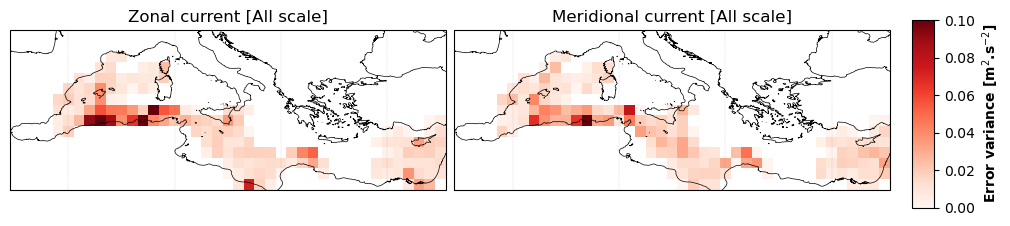

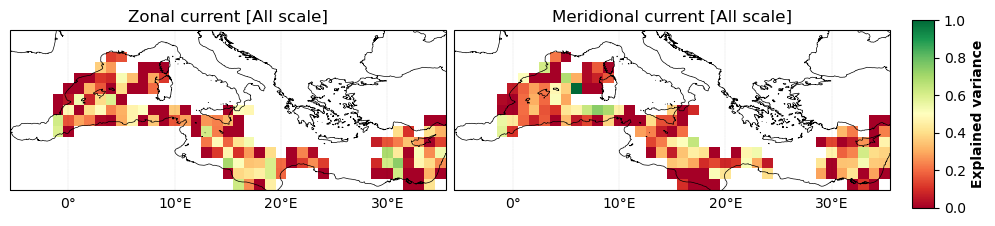

In [22]:
# Plot gridded stats
# Hvplot
# plot_stat_score_map_uv(stat_output_filename)
# Matplotlib
plot_stat_score_map_uv_png(stat_output_filename, box_lonlat=box_lonlat)

The figure shows that the maximum mapping errors are found in intense current systems, for example in the GulfStream, Kuroshio and Agulhas regions. 

However, when considering the full scale of motion in the drifter database, the surface current maps capture up to 80% of the variability of drifter currents in the Western Boundary Currents and Antarctic Circumpolar Currents (ACC). The geostrophic signal dominates the ageostrophic signal in these regions. In regions with low ocean variability, only a few percent of the total drifter current variability is recovered in the maps, which may be associated with a larger ageostrophic signal in these regions.

In [23]:
plot_stat_uv_by_regimes(stat_output_filename)

,mapping_err_u_var [m²/s²],mapping_err_v_var [m²/s²],ugos_interpolated_var [m²/s²],EWCT_var [m²/s²],vgos_interpolated_var [m²/s²],NSCT_var [m²/s²],var_score_u_allscale,var_score_v_allscale
coastal,0.019732,0.018264,0.014168,0.032612,0.010029,0.027384,0.39494,0.333027
offshore_highvar,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
offshore_lowvar,0.015672,0.017204,0.012288,0.024263,0.007381,0.026708,0.35410,0.355870
equatorial_band,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
arctic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
antarctic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
compute_temporal_rmse(ds_interp, method_name, time_min, time_max, rmse_filename, var_type='uv')

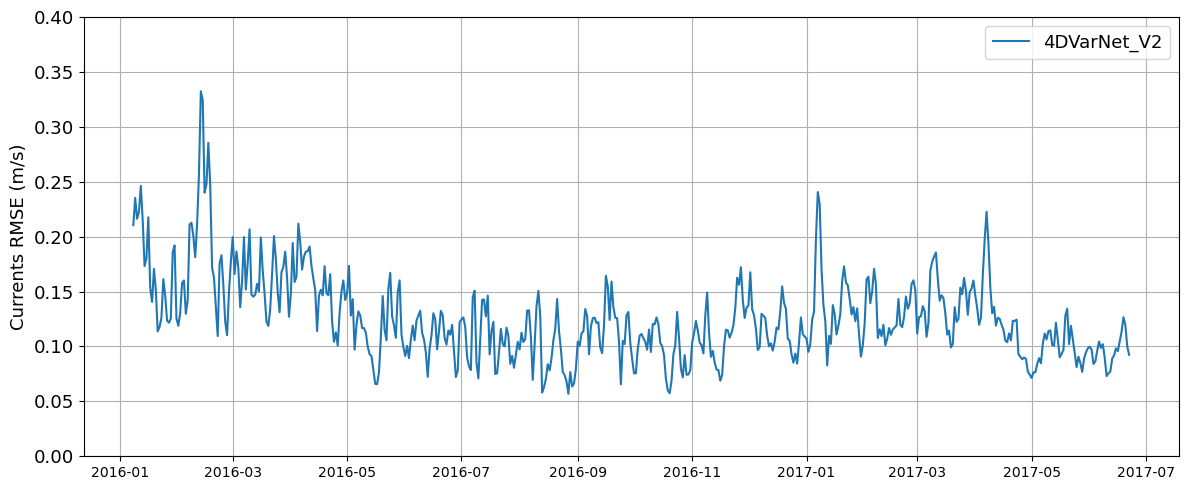

In [25]:
plot_temporal_rmse(rmse_filename, var_type='uv')